# `CostOptimizer` Class Demo

6/19/2023

Mark Green

This section runs an optionally-constrained **P**article **S**warm **O**ptimizer optimization of `EconomicLoss` function for CaUWMET model.

First use ipykernel `pip` to install and import libraries. Then define the `CostOptimizer` - a `pymoo` problem class for the CaUWMET model. 


In [1]:
!pip install numpy matplotlib pymoo

from IPython.core.debugger import set_trace  # use set_trace to engage ipy debugger like pdb

import time
import numpy as np
import warnings

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.termination import get_termination
from pymoo.optimize import minimize

from src.modelLogic.modelLogic import ModelLogic
from src.modelLogic.inputData import InputData
from src.modelLogic.storageUtilities import StorageUtilities
from src.modelLogic.inputDataLocations import InputDataLocations

warnings.filterwarnings('ignore')  # turn off warnings

In [2]:
### PyMoo Optimization Problem Class ###

class CostOptimizer(ElementwiseProblem): 
    '''
    This class is a PyMoo problem class designed to simulate the effects of longtermWMOSupply levels...
    ...on water usage cost optimization (economicLoss) for a given contractor. 
    The objective space of F(X) is mapped by an algorithm, within the u/l bounds for each dimension of X.
    Optionally, F(X) can be constrained by inequality constraints G(X): 
       + g1(x) > wmoFloor  :: defines a floor value of the sum( longtermWMOSupply ) 
       + g2(x) < wmoSupply :: defines a ceiling value of the sum( longtermWMOSupply )
    https://pymoo.org/
    '''
    def __init__(self, 
                 lowerBounds: list,          # lower bound of each longtermWMO type for a given scenario - len(list)=8
                 upperBounds: list,          # upper bound of each longtermWMO type for a given scenario - len(list)=8
                 modelLogic: ModelLogic,     # prepared ModelLogic object with InputData and StorageUtilities
                 wmoFloor=None,              # how low are we constraining the sum longtermWMOs?
                 wmoSupply=None,             # how high are we constraining the sum longtermWMOs?
                 **kwargs):    
        '''
        Initializing the CostOptimizer class requires parameterizing a CaUWMET model for a given contractor.
        Inputs:
            wmoFloor/wmoSupply :: number > 0, max sum of the longtermWMO allocations
            lowerBounds/upperBounds :: list of numbers, length 8
            modelLogic :: ModelLogic object loaded with InputData, StorageUtilities, and Contractor
        '''
        self.wmoFloor = wmoFloor if wmoFloor is not None else None
        self.wmoSupply = wmoSupply if wmoSupply is not None else None
        self.n_ieq_constr = sum([i != None for i in [self.wmoFloor, self.wmoSupply]])
        self.lowerBounds = lowerBounds
        self.upperBounds = upperBounds
        self.objectiveFunction = modelLogic.executeModelLogicForContractor  # execute ModelLogic
        
        super().__init__(  # parameterize the objective function
            n_var=8, n_obj=1, n_ieq_constr=self.n_ieq_constr, 
            xl=self.lowerBounds, xu=self.upperBounds,  # xl and xu set longtermWMOSupply bounds 
            **kwargs
        )


    def _evaluate(self, x, out, *args, **kwargs):
        '''
        Inputs:
           x :: list of numbers, length 8
        Returns objective function f(x)
        Returns inequality constraints g(x)
        '''
        tic = time.perf_counter()
        if self.n_ieq_constr > 0:
            out["F"] = self.objectiveFunction(x)
            G1 = self.wmoFloor - np.sum(x)   # np.sum(x) >= self.wmoFloor
            G2 = np.sum(x) - self.wmoSupply  # self.wmoSupply >= np.sum(x)
            out["G"] = [G1, G2]
        else:
            out["F"] = self.objectiveFunction(x)
        toc = time.perf_counter()
        

## Run the model

This section runs the model. Feel free to play with some of the inputs

In [3]:
### instantiate CaUWMET model and execute MOO problem ###
inputData = InputData(InputDataLocations())
modelLogic = ModelLogic(inputData, StorageUtilities())
modelLogic.contractor = 'Metropolitan Water District of Southern California'

wmoSupply = None  # num > 0 or None
wmoFloor = None  # num > 0 or None

year = '2045'

upperBounds = [
    inputData.longtermWMOSurfaceVolumeLimit[inputData.longtermWMOSurfaceVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOGroundwaterVolumeLimit[inputData.longtermWMOGroundwaterVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMODesalinationVolumeLimit[inputData.longtermWMODesalinationVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMORecycledVolumeLimit[inputData.longtermWMORecycledVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOPotableReuseVolumeLimit[inputData.longtermWMOPotableReuseVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOTransfersExchangesVolumeLimit[inputData.longtermWMOTransfersExchangesVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOOtherSupplyVolumeLimit[inputData.longtermWMOOtherSupplyVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOConservationVolumeLimit[inputData.longtermWMOConservationVolumeLimit.index==modelLogic.contractor][year][0],
]
#upperBounds = [20]*8
lowerBounds = [5]*8

# parameterize the problem
problem = CostOptimizer(
    wmoFloor=wmoFloor, wmoSupply=wmoSupply, 
    lowerBounds=lowerBounds, upperBounds=upperBounds,
    modelLogic=modelLogic
)

# instantiate algorithm
# TODO: hyperparameter tuning
algorithm = PSO(
    pop_size=10,
    w=0.9, c1=5.0, c2=1.0,
    adaptive=True,
    max_velocity_rate=0.2
)

# parameterize the termination criteria
termination = get_termination("n_gen", 5)

# execute optimization
res = minimize(
    problem, 
    algorithm, 
    termination, 
    seed=42, 
    verbose=True,
    save_history=True
)
    
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       10 |        - |       - |  0.9000 |  5.00000 |  1.00000 |  5.243258E+09 |  5.243256E+09
     2 |       20 | -3.8E-02 |       3 |  0.3765 |  2.50000 |  1.50000 |  5.243257E+09 |  5.243255E+09
     3 |       30 |  0.28826 |       2 |  0.5852 |  2.50000 |  1.50000 |  5.243256E+09 |  5.243255E+09
     4 |       40 | -4.4E-02 |       3 |  0.3731 |  2.48283 |  1.52367 |  5.243256E+09 |  5.243255E+09
     5 |       50 |  0.03418 |       3 |  0.4215 |  2.46395 |  1.54982 |  5.243255E+09 |  5.243255E+09
Best solution found: 
X = [9.22994651 7.38546552 8.19573636 8.61223888 6.81785045 9.59497218
 9.99783393 7.79506834]
F = [5.24325504e+09]


## Visualization

This section visualizes the results. Needs some work still, but is a preview of the TAF vs Loss plot.


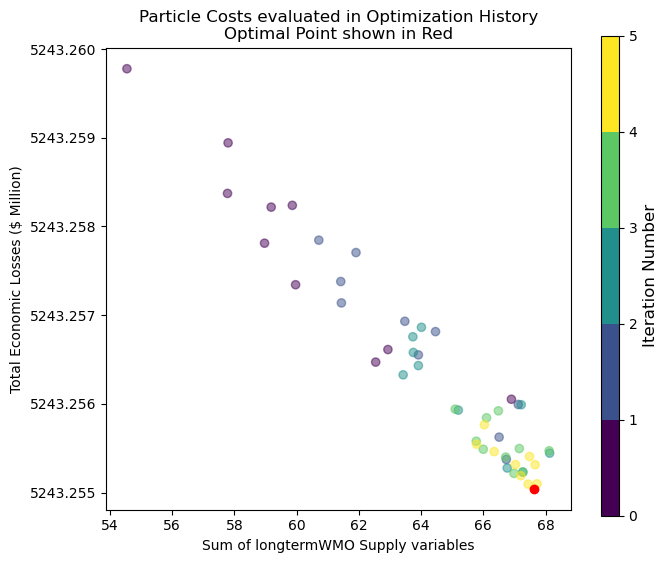

In [4]:
### plot particle results history ###

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

X = []
F = []

# get the particles
for h in res.history:
    for p in h.particles:
        X.append(p._X)
        F.append(p._F)
        
TAF = np.sum(X,axis=1)  # sum of longtermWMOSupply variables
loss_millions = [f*10**-6 for f in F]
colors = [item for item in [0,1,2,3,4] for i in range(10)]  # this only works for the n_gen=5 because of this....

fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

cmap = plt.cm.viridis  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from map
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N
)

# define the bins and normalize
bounds = np.linspace(0, 5, 6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax.scatter(TAF, loss_millions, c=colors, cmap=cmap, norm=norm, alpha=0.5)
ax.set_title("Particle Costs evaluated in Optimization History\nOptimal Point shown in Red")
ax.set_xlabel("Sum of longtermWMO Supply variables")
ax.set_ylabel("Total Economic Losses ($ Million)")
ax.ticklabel_format(axis="y", style="sci", useOffset=False)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(
    ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i'
)
ax2.set_ylabel('Iteration Number', size=12)

# plot the best result in red
ax.scatter(x=sum(res.X), y=res.F*10**-6, c='red')
        

# Development

The cells below here are just used for development. Ignore! the section above is meant for demo and playing. 

In [5]:
ax

<Axes: title={'center': 'Particle Costs evaluated in Optimization History\nOptimal Point shown in Red'}, xlabel='Sum of longtermWMO Supply variables', ylabel='Total Economic Losses ($ Million)'>

In [6]:
res.__dict__

{'opt': Population([<pymoo.core.individual.Individual object at 0x7f6002bc97e0>],
            dtype=object),
 'success': None,
 'message': None,
 'problem': <__main__.CostOptimizer at 0x7f60103ea050>,
 'archive': None,
 'pf': None,
 'algorithm': <pymoo.algorithms.soo.nonconvex.pso.PSO at 0x7f60102a6470>,
 'pop': Population([<pymoo.core.individual.Individual object at 0x7f6002b2fd90>,
            dtype=object),
 'X': array([9.22994651, 7.38546552, 8.19573636, 8.61223888, 6.81785045,
        9.59497218, 9.99783393, 7.79506834]),
 'F': array([5.24325504e+09]),
 'CV': array([0.]),
 'G': array([], dtype=float64),
 'H': array([], dtype=float64),
 'start_time': 1687220655.088033,
 'end_time': 1687220681.3007083,
 'exec_time': 26.21267533302307,
 'history': [<pymoo.algorithms.soo.nonconvex.pso.PSO at 0x7f60102a6e00>,
  <pymoo.algorithms.soo.nonconvex.pso.PSO at 0x7f60102a6fb0>]}

In [7]:
res.history[3].particles[0].__dict__

{'_X': array([9.39994134, 6.3765106 , 9.04687271, 7.3752269 , 7.36402514,
        9.04239162, 9.67179785, 8.99114103]),
 '_F': array([5.24325523e+09]),
 '_G': array([], dtype=float64),
 '_H': array([], dtype=float64),
 '_dF': array([], dtype=float64),
 '_dG': array([], dtype=float64),
 '_dH': array([], dtype=float64),
 '_ddF': array([], dtype=float64),
 '_ddG': array([], dtype=float64),
 '_ddH': array([], dtype=float64),
 '_CV': array([0.]),
 'evaluated': {'F', 'G', 'H'},
 'data': {'V': array([ 0.22029743,  0.22029743,  0.22029743,  0.22029743,  0.22029743,
         -0.12731192, -0.02276382, -0.02654665]),
  'n_gen': 4,
  'n_iter': 4},
 'config': {'cache': True,
  'cv_eps': 0.0,
  'cv_ieq': {'scale': None,
   'eps': 0.0,
   'pow': None,
   'func': <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>},
  'cv_eq': {'scale': None,
   'eps': 0.0001,
   'pow': None,
   'func': <function numpy.sum(a, axis=None, dtype=None, out=No

In [8]:
res.exec_time?

Type:        float
String form: 26.21267533302307
Docstring:   Convert a string or number to a floating point number, if possible.

### Parallelization Test

simple PSO optimization

No constraints, attempt to parallelize with `multiprocessing` 

https://docs.python.org/3/library/multiprocessing.html?highlight=multiprocessing#multiprocessing.pool.Pool.starmap

In [ ]:
### Attempt to Parallelize ###

from IPython.core.debugger import set_trace

import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from src.modelLogic.modelLogic import ModelLogic
from src.modelLogic.inputData import InputData
from src.modelLogic.storageUtilities import StorageUtilities
from src.modelLogic.inputDataLocations import InputDataLocations

from multiprocessing.pool import ThreadPool
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.termination import get_termination
from pymoo.optimize import minimize

# instantiate CaUWMET model and variables
inputData = InputData(InputDataLocations())
modelLogic = ModelLogic(inputData, StorageUtilities())
modelLogic.contractor = 'Metropolitan Water District of Southern California'

year = '2045'

upperBounds = [
    inputData.longtermWMOSurfaceVolumeLimit[inputData.longtermWMOSurfaceVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOGroundwaterVolumeLimit[inputData.longtermWMOGroundwaterVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMODesalinationVolumeLimit[inputData.longtermWMODesalinationVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMORecycledVolumeLimit[inputData.longtermWMORecycledVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOPotableReuseVolumeLimit[inputData.longtermWMOPotableReuseVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOTransfersExchangesVolumeLimit[inputData.longtermWMOTransfersExchangesVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOOtherSupplyVolumeLimit[inputData.longtermWMOOtherSupplyVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOConservationVolumeLimit[inputData.longtermWMOConservationVolumeLimit.index==modelLogic.contractor][year][0]
]
lowerBounds = [0]*8

# initialize the thread pool and create the runner for parallelizaiton via Starmap
n_threads = 4
pool = ThreadPool(n_threads)

### PyMoo Optimization Problem ###

class CostOptimizer(ElementwiseProblem):
    '''
    This class is a PyMoo problem class designed to simulate the effects of wmoSupply level...
    ...on water usage cost optimization across various sources.
    
    The objective function f(x) has an equality constraint g(x) = wmoSupply.
    The algorithm is a particle swarm optimizer with default settings. 
    
    https://pymoo.org/
    '''
    def __init__(self, 
                 lowerBounds: list,          # lower bound of each WMO type for a given scenario - len(list)=8
                 upperBounds: list,          # upper bound of each WMO type for a given scenario - len(list)=8
                 modelLogic: ModelLogic,     # prepared ModelLogic object with InputData and StorageUtilities
                 **kwargs):    
        '''
        Initializing the CostOptimizer class requires parameterizing a given CaUWMET model
        for a given contractor and requested wmoSupply.
        Inputs:
            upperBounds/lowerBounds :: list of numbers, length 8
            modelLogic :: ModelLogic object loaded with InputData, StorageUtilities, and Contractor
        '''
        self.lowerBounds = lowerBounds       # list length 8 lower bounding WMOs
        self.upperBounds = upperBounds       # list length 8 upper bounding WMOs
        self.objectiveFunction = modelLogic.executeModelLogicForContractor  # modelLogic.execute
        
        # parameterize the objective function
        super().__init__(
            **kwargs, n_var=8, n_obj=1, #n_eq_constr=1, 
            xl=self.lowerBounds, xu=self.upperBounds    # xl and xu set f bounds 
        )


    def _evaluate(self, X, out, *args, **kwargs):
        tic = time.perf_counter()
        
        # prepare the parameters for the pool
        params = [[X[k]] for k in range(len(X))]

        # calculate the function values in a parallelized manner and wait until done
        F = pool.starmap(self.objectiveFunction, params)
        
        # store the function values and return them.
        out["F"] = np.array(F)
        
        toc = time.perf_counter()


# parameterize the problem
problem = CostOptimizer(
    lowerBounds=lowerBounds, upperBounds=upperBounds, modelLogic=modelLogic
)

# parameterize algorithm
algorithm = PSO(
    pop_size=10,
    w=0.9, c1=5.0, c2=1.0,
    adaptive=True,
    max_velocity_rate=0.2
)

# parameterize the termination criteria
termination = get_termination("n_gen",5)

# execute optimization
res = minimize(
    problem, 
    algorithm, 
    termination, 
    seed=42, 
    verbose=True,
    save_history=True
)
    
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
print('Threads:', res.exec_time)

pool.close()

### Constraint Handling Test

simple PSO optimization

no parallelization, attempt to constrain to WMOsupply

https://pymoo.org/constraints/index.html

In [ ]:
from IPython.core.debugger import set_trace

import time
import numpy as np
#from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

#from tests.test_modelLogic.py import ModelLogic
#from tests.test_inputDataLocationsForTesting import InputDataLocationsForTesting
#from tests.test_storageOperations import StorageUtilities

from src.modelLogic.modelLogic import ModelLogic
from src.modelLogic.inputData import InputData
from src.modelLogic.storageUtilities import StorageUtilities
from src.modelLogic.inputDataLocations import InputDataLocations

from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.termination import get_termination
from pymoo.optimize import minimize

### PyMoo Optimization Problem ###

class CostOptimizer(Problem): #Problem):
    '''
    This class is a PyMoo problem class designed to simulate the effects of wmoSupply level...
    ...on water usage cost optimization across various sources.
    
    The objective function f(x) has an equality constraint g(x) = wmoSupply.
    The algorithm is a particle swarm optimizer with default settings. 
    
    https://pymoo.org/
    '''
    def __init__(self, 
                 wmoSupply: int,             # how much are we allocating to the longterm WMOs? int for now...
                 upperBounds: list,          # upper bound of each WMO type for a given scenario - len(list)=8
                 modelLogic: ModelLogic,     # prepared ModelLogic object with InputData and StorageUtilities
                 **kwargs):    
        '''
        Initializing the CostOptimizer class requires parameterizing a given CaUWMET model
        for a given contractor and requested wmoSupply.
        Inputs:
            wmoSupply :: integer (for now..., could later be a number)
            upperBounds :: list of numbers, length 8
            modelLogic :: ModelLogic object loaded with InputData, StorageUtilities, and Contractor
        '''
        self.wmoSupply = wmoSupply           # must be greater than 0
        self.upperBounds = upperBounds       # list length 8 upper bounding WMOs
        self.objectiveFunction = modelLogic.execute # modelLogic.executeModelLogicForContractor
        
        # parameterize the objective function
        super().__init__(
            **kwargs, n_var=8, n_obj=1, #n_eq_constr=1, 
            xl=[0]*8, xu=self.upperBounds    # xl and xu set f bounds 
        )


    def _evaluate(self, x, out, *args, **kwargs):
        '''
        Inputs:
           x :: list of numbers, length 8
        Returns objective function f(x) as execution of model logic
        Returns equality constraint h(x) as wmoSupply - sum(x) = 0
        ''' 
        tic = time.perf_counter()
        out["F"] = self.objectiveFunction(x)
        toc = time.perf_counter()
        
        #print("-------+----------+")
        #print(f"Time: {toc-tic:.2f} s")
        #print("-------+----------+")
#        print(f"{(self.wmoSupply - np.sum(x,axis=1)).shape}")
#        print(f"{self.wmoSupply - np.sum(x,axis=1)}")
        #out["H"] = self.wmoSupply - np.sum(x, axis=1)

# instantiate CaUWMET model and variables
inputData = InputData(InputDataLocations())
modelLogic = ModelLogic(inputData, StorageUtilities())
modelLogic.contractor = 'Metropolitan Water District of Southern California'

year = '2045'

#upperBounds = [
#    inputData.longtermWMOSurfaceVolumeLimit[inputData.longtermWMOSurfaceVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOGroundwaterVolumeLimit[inputData.longtermWMOGroundwaterVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMODesalinationVolumeLimit[inputData.longtermWMODesalinationVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMORecycledVolumeLimit[inputData.longtermWMORecycledVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOPotableReuseVolumeLimit[inputData.longtermWMOPotableReuseVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOTransfersExchangesVolumeLimit[inputData.longtermWMOTransfersExchangesVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOOtherSupplyVolumeLimit[inputData.longtermWMOOtherSupplyVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOConservationVolumeLimit[inputData.longtermWMOConservationVolumeLimit.index==modelLogic.contractor][year][0],
#]

upperBounds = [50]*8
wmoSupply = 500

# parameterize the problem
problem = CostOptimizer(
    wmoSupply=wmoSupply, upperBounds=upperBounds, modelLogic=modelLogic
)

# parameterize algorithm
algorithm = PSO(
    pop_size=10,
    w=0.9, c1=5.0, c2=1.0,
    adaptive=True,
    max_velocity_rate=0.2
)

# parameterize the termination criteria
termination = get_termination("n_gen", 10)

# execute optimization
res = minimize(
    problem, 
    algorithm, 
    termination, 
    seed=42, 
    verbose=True,
    save_history=False
)
    
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
